pandas-ylt
===========

Python modules for working in pandas with various loss data tables used for CAT modelling


## Example YELT
In this case there is a separate index level for the Model ID, which categorises groups of events. There are also two loss perspectives stored in separate columns of a dataframe. 

In [1]:
import pandas as pd
from pandas_ylt import yeareventloss

yelts = pd.read_csv("tests/_data/example_two_models_grossnet.csv")
yelts = yelts.set_index(['Year', 'ModelID', 'EventID', 'DayOfYear'])
yelts.attrs['n_yrs'] = 1e5
display(yelts)

GrossLoss  NetLoss
Year   ModelID EventID DayOfYear                      
1      Model1  45902   189        1313.996261      0.0
               33305   232        2540.574756      0.0
2      Model1  30597   54         1468.851587      0.0
4      Model1  10078   63         1677.475382      0.0
5      Model1  7014    9          1852.600528      0.0
...                                       ...      ...
99995  Model2  19599   54         1024.742827      0.0
               40252   362        2469.358250      0.0
99999  Model2  72370   2          3170.787193      0.0
               83257   282        3533.693832      0.0
100000 Model2  48460   315        1016.256966      0.0

[149727 rows x 2 columns]

### Partitioning of the YLT
We can create a Year Loss Table, but retain the split between model ID in separate columns.

In [2]:
ylt_bymodel = (yelts['GrossLoss'].yel
               .to_ylt_partitioned(splitby='ModelID')
               )
display(ylt_bymodel.head())
# ylt_bymodel.attrs


ModelID,Model1,Model2
Year,,
1,3854.571017,0.000000
2,1468.851587,1010.143253
3,0.000000,1788.244284
4,1677.475382,1190.315697
5,34999.439551,0.000000


We can combine the partitioned YLT with the total YLT and its EP curve

In [3]:
partitioned_aepcurve = (ylt_bymodel
 .join(yelts['GrossLoss'].yel.to_ylt())
 .join(yelts['GrossLoss'].yel.to_ylt().yl.exprob())
 .sort_values('ExProb', ascending=True)
)
display(partitioned_aepcurve)

,Model1,Model2,GrossLoss,ExProb
Year,,,,
22644,3.628133e+07,3.037980e+03,3.628437e+07,0.00001
79142,1.663761e+07,0.000000e+00,1.663761e+07,0.00002
54662,1.205647e+07,0.000000e+00,1.205647e+07,0.00003
10432,1.079823e+07,1.608848e+03,1.079983e+07,0.00004
79360,0.000000e+00,1.007540e+07,1.007540e+07,0.00005
...,...,...,...,...
15814,0.000000e+00,1.000083e+03,1.000083e+03,0.77508
44281,0.000000e+00,1.000077e+03,1.000077e+03,0.77509
35831,0.000000e+00,1.000077e+03,1.000077e+03,0.77510


Visualise the split as a stacked survivor function

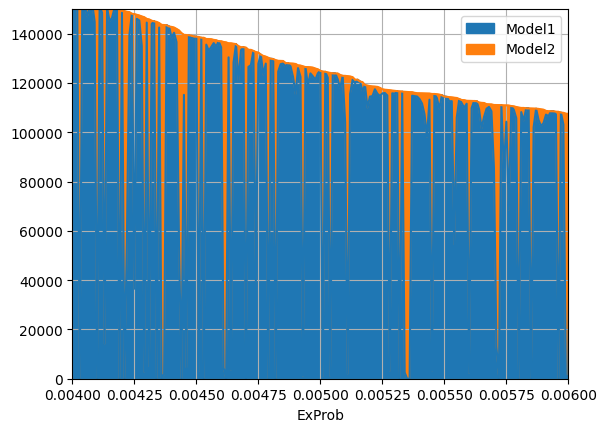

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1)
(partitioned_aepcurve
 .sort_values('ExProb', ascending=True)
 .plot.area(x='ExProb', y=['Model1', 'Model2'], ax=ax)
)
ax.set(xlim=(0.004, 0.006), ylim=(0, 150e3))
ax.grid(True)
plt.show()

We can also look at the average contribution of each model at each exceedance probability

In [5]:
tvar_bymodel = partitioned_aepcurve.copy().sort_values('ExProb', ascending=True)
tvar_bymodel['TVaR'] = tvar_bymodel['GrossLoss']

for c in ['Model1', 'Model2', 'TVaR']:
    tvar_bymodel[c] = tvar_bymodel[c].cumsum() / (ylt_bymodel.attrs['n_yrs'] * tvar_bymodel['ExProb'])
tvar_bymodel



,Model1,Model2,GrossLoss,ExProb,TVaR
Year,,,,,
22644,3.628133e+07,3.037980e+03,3.628437e+07,0.00001,3.628437e+07
79142,2.645947e+07,1.518990e+03,1.663761e+07,0.00002,2.646099e+07
54662,2.165847e+07,1.012660e+03,1.205647e+07,0.00003,2.165948e+07
10432,1.894341e+07,1.161707e+03,1.079983e+07,0.00004,1.894457e+07
79360,1.515473e+07,2.016009e+06,1.007540e+07,0.00005,1.717074e+07
...,...,...,...,...,...
15814,7.178394e+03,4.012436e+03,1.000083e+03,0.77508,1.119083e+04
44281,7.178301e+03,4.012397e+03,1.000077e+03,0.77509,1.119070e+04
35831,7.178208e+03,4.012358e+03,1.000077e+03,0.77510,1.119057e+04


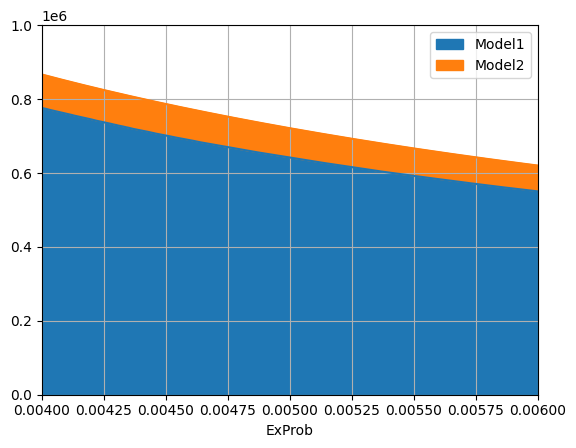

In [6]:

fig, ax = plt.subplots(1)
(tvar_bymodel
 .plot.area(x='ExProb', y=['Model1', 'Model2'], ax=ax)
)
ax.set(xlim=(0.004, 0.006), ylim=(0, 1e6))
# ax.set(xscale='log')
ax.grid(True)
plt.show()